In [1]:
library(tidyverse)
library(patchwork)
library(magrittr)
library(brms)
library(ggforce)
library(magick)
library(cowplot)
tts <- 24
tts_small <- 20
theme_set(theme_classic(base_size = tts))
source("../color_df.R")
options(repr.plot.width = 20, repr.plot.height = 12, repr.plot.res = 200)


── Attaching packages ──────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ─────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: Rcpp

Loading 'brms' package (version 2.13.5). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


Linking to ImageMagick 7.0.10.28
Enabled features: cairo, fontconfig, freetype, fftw, pango, rsvg, webp, x11
D

In [2]:
#linkedsel data
linkedsel_val_df <- read_csv("linkedsel_predDF.csv")

theta_plot_df <- distinct(select(linkedsel_val_df, lower, value, upper, pop))

mean_pi_df <- 
    linkedsel_val_df %>% 
    group_by(pop) %>% 
    summarise(pi = mean(pi))

linkedsel_best_mod  <- read_csv("linkedsel_best_modDF.csv")
mu_int <- 8
best_fit_list <- readRDS(str_glue("bgs_bestfit_mu-{mu_int}.rds"))
aic_df <- map_df(best_fit_list, ~ .x$aic_df)
conf_df <- map_df(best_fit_list, ~ .x$conf_df) %>% mutate(pop = str_remove_all(pop, "(v5--|.100000BP)"))
pred_df <- map_df(best_fit_list, ~ .x$pred_df)


#aMK data
pred_df <- read_csv(, file = "aMK_predDF.csv")
full_pred <- read_csv(, file = "aMK_allpredDF.csv")


model_plot_df <- filter(conf_df, model %in% c("full", "intercept"), param == "theta") %>%
    full_join(
        mutate(color_df, pop = str_replace_all(pop, "(Teo|LR)_", "\\1--")), 
        conf_df, , by = "pop") %>% 
    filter(!pop %in% c("LR--random2_Palmar_Chico", "LR--Palmar_Chico", "Teo--random2_Palmar_Chico", "Teo--Palmar_Chico")) %>% 
    drop_na() %>% 
    separate(pop, into = c("ssp", "pop"), sep = "--")


plot_df <- full_pred %>% 
  filter(nuc_type == "All") %>% 
  filter(!pop %in% c("LR_random2_Palmar_Chico", "LR_Palmar_Chico", "Teo_random2_Palmar_Chico", "Teo_Palmar_Chico"))  %>% 
  mutate(pop = str_remove_all(pop, "(LR_|Teo_)")) %>%
  full_join(., model_plot_df, by = c("pop", "ssp"))



── Column specification ─────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  chr = col_character(),
  model = col_character(),
  mode = col_character(),
  pop = col_character(),
  param = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ─────────────────────────────────────────────────────────────────
cols(
  model = col_character(),
  nLL = col_double(),
  AIC = col_double(),
  AIC_delta = col_double(),
  AIC_weight = col_double(),
  pop = col_character(),
  mode = col_character(),
  s = col_double(),
  mu = col_double(),
  h = col_double()
)



── Column specification ─────────────────────────────────────────────────────────────────
cols(
  ssp = col_character(),
  nuc_type = col_character(),
  pop = col_character(),
  allele_frequency = col_double()
)



── Column specification ─────────────────────────────────────────────────────────────────
cols(
  alpha = col_double(),
  error = col_do

In [3]:
nrow(linkedsel_val_df)

[1] 17000

In [4]:
tpt <- max(filter(linkedsel_val_df, pop == "LR--random1_Palmar_Chico")$rbp_i)
tpt <- 2
pc_theta <- filter(theta_plot_df, pop == "LR--random1_Palmar_Chico")$value
pc_pi <- filter(mean_pi_df, pop == "LR--random1_Palmar_Chico")$pi

pi_rate <- 
linkedsel_val_df %>% 
    filter(pop == "LR--random1_Palmar_Chico") %>%
    #mutate(rbp_i = log10(rbp_i)) %>% 
    ggplot()+
    geom_point(mapping = aes(rbp_i, pi), alpha = 0.2, size = 2) + 
    geom_ribbon(mapping = aes(x = rbp_i, ymin = low, ymax =  high), fill = "grey50", alpha = 0.2) +
    geom_hline(yintercept = pc_theta, lty = 2) +
    geom_point(aes(tpt, pc_theta), shape = 16, size = 4) +
    geom_point(aes(tpt, pc_pi), shape = 17, size = 4) +
    geom_line(mapping = aes(rbp_i, expected_pi), colour = "violetred") +
    xlab("cM/Mb") +
    facet_wrap(~pop, labeller = labeller(pop = c("LR--random1_Palmar_Chico" = "Maize Palmar Chico"))) +
    theme(strip.text.x = element_text(size = tts_small*0.5)) +
    ylab(expression(pi)) +
    facet_zoom(xlim = c(0, 2))
    

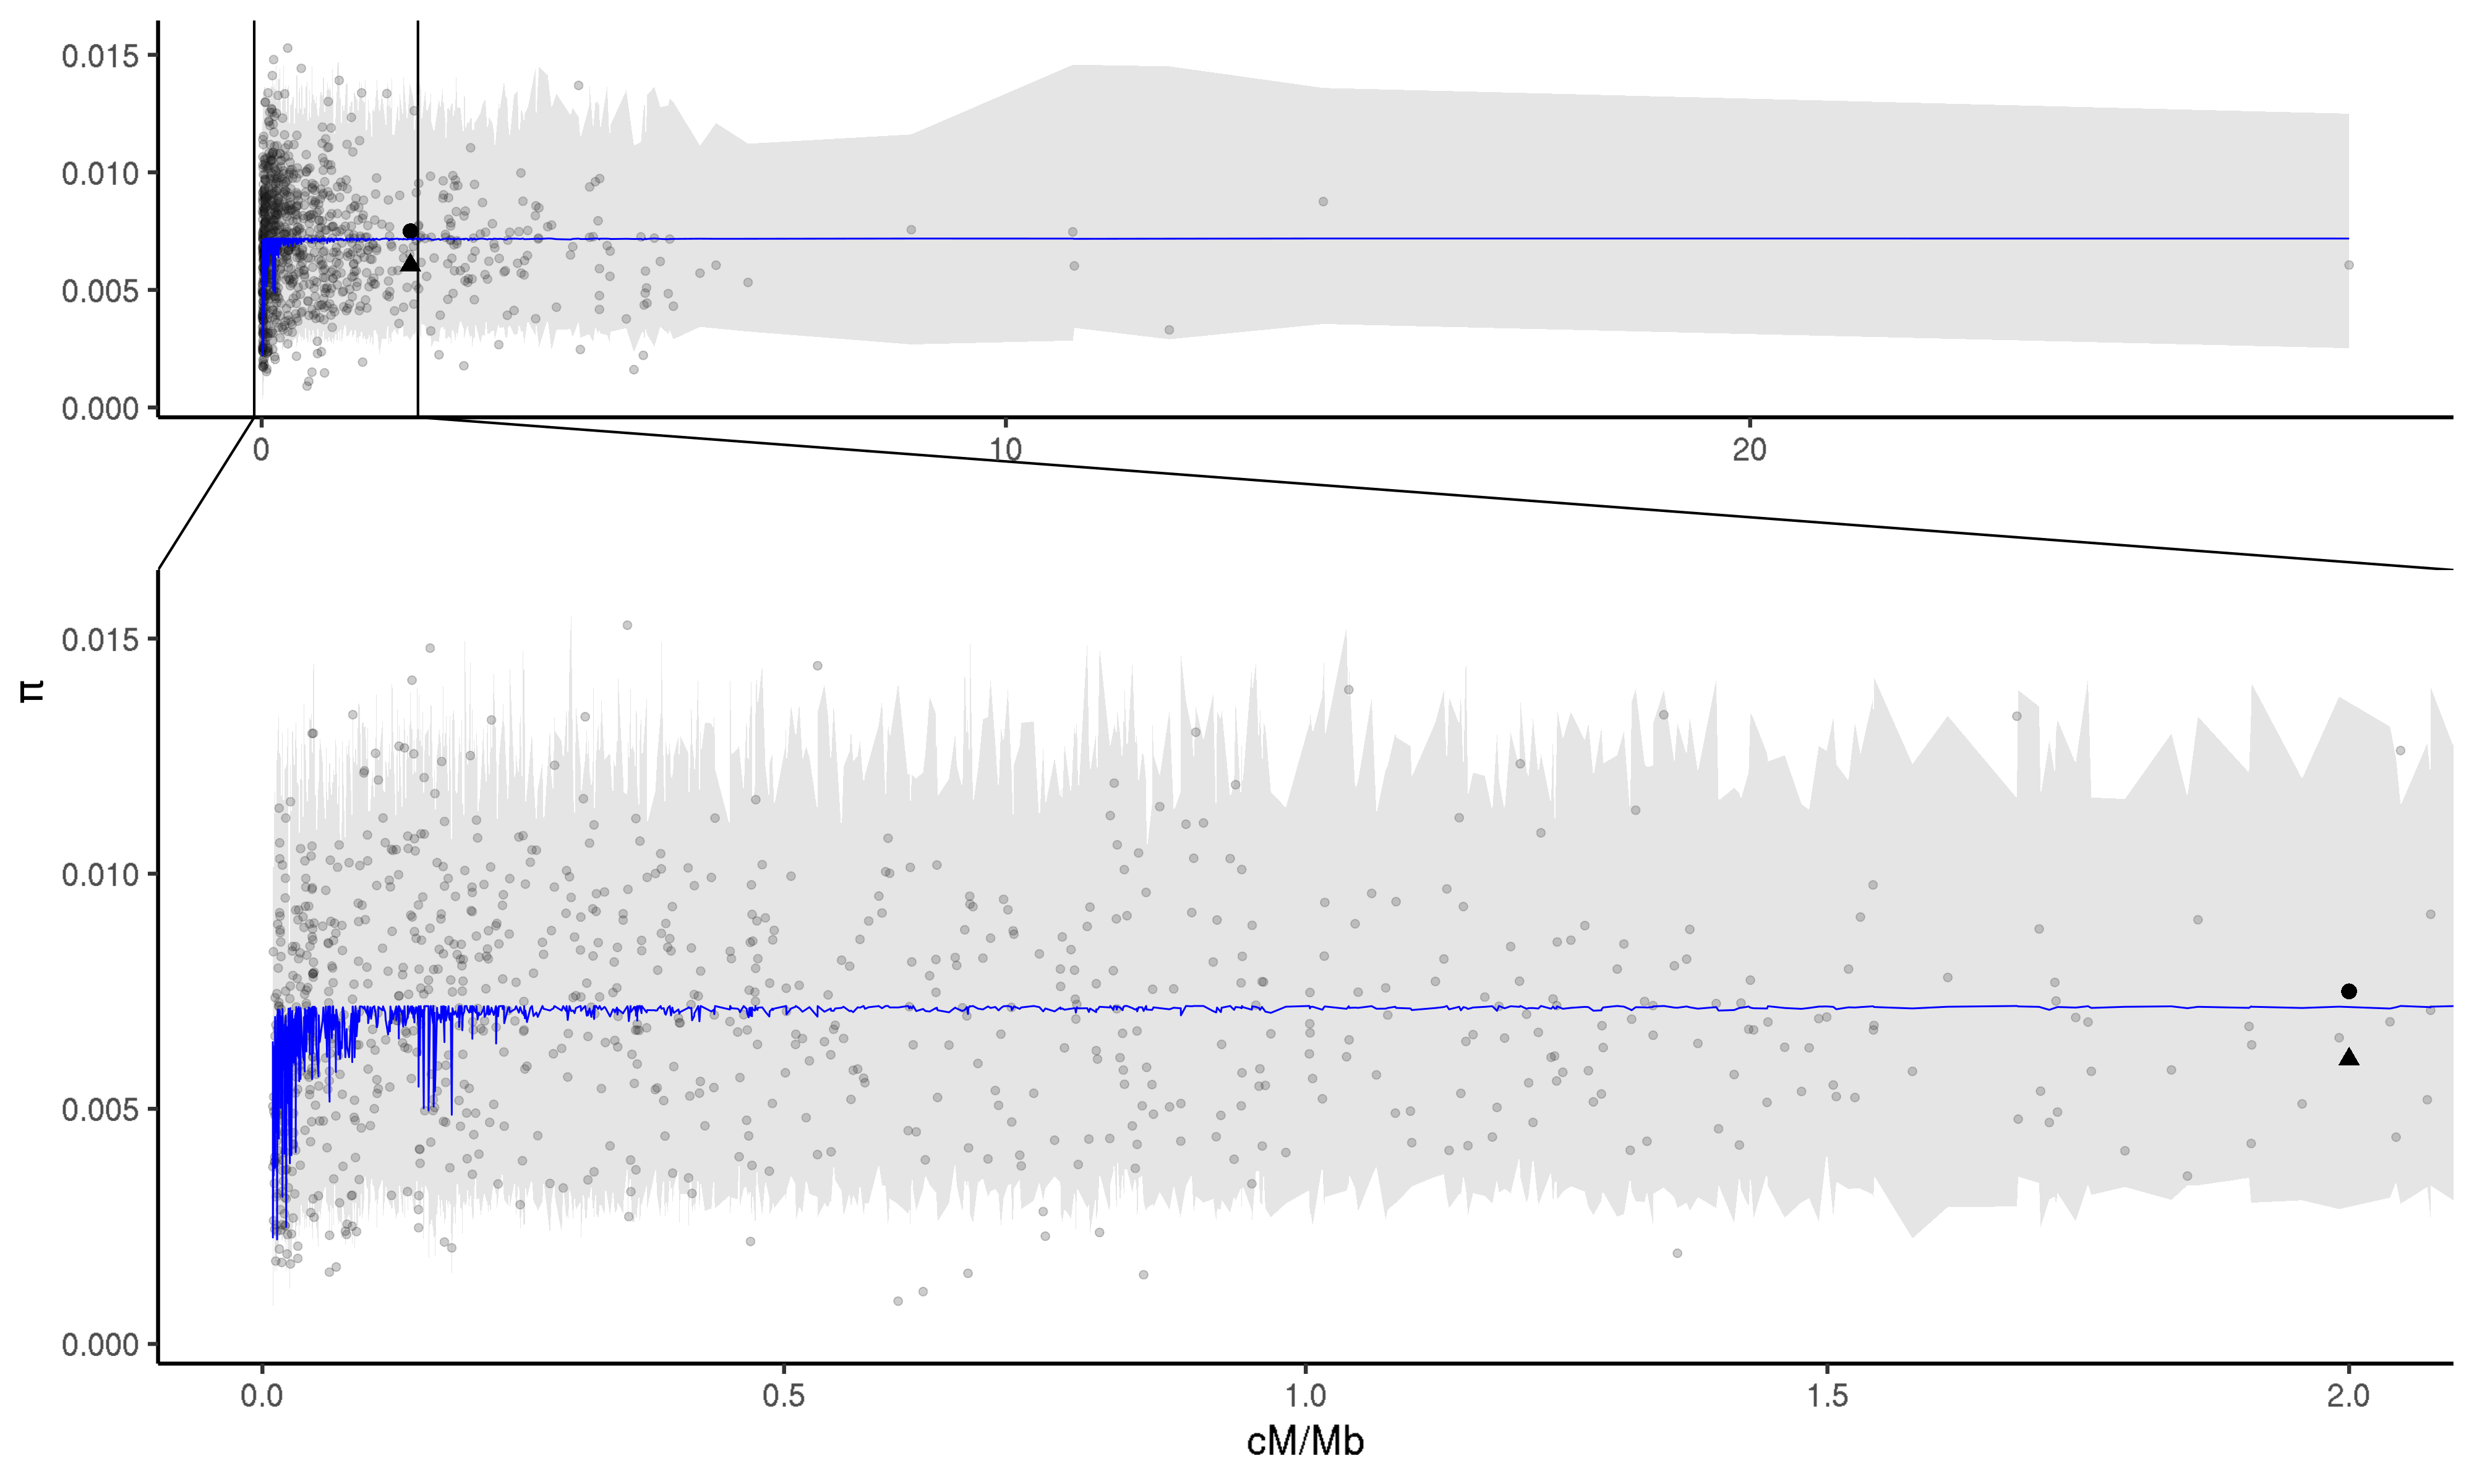

In [5]:
linkedsel_val_df %>% 
    filter(pop == "Teo--San_Lorenzo") %>%
    #mutate(rbp_i = log10(rbp_i)) %>% 
    ggplot()+
    geom_point(mapping = aes(rbp_i, pi), alpha = 0.2, size = 2) + 
    geom_ribbon(mapping = aes(x = rbp_i, ymin = low, ymax =  high), fill = "grey50", alpha = 0.2) +
    geom_point(aes(tpt, pc_theta), shape = 16, size = 4) +
    geom_point(aes(tpt, pc_pi), shape = 17, size = 4) +
    geom_line(mapping = aes(rbp_i, expected_pi), colour = "blue") +
    xlab("cM/Mb") +
    facet_wrap(~pop) +
    theme(strip.text.x = element_text(size = tts_small)) +
    ylab(expression(pi)) +
    facet_zoom(xlim = c(0, 2))

Warning message in cor.test.default(value, alpha, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  value and alpha
S = 23.669, p-value = 2.556e-07
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9479798 



Call:
lm(formula = alpha ~ value, data = filter(plot_df, ssp == "Teo"))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.021554 -0.010914 -0.003567  0.003867  0.039279 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.3277     0.0352   -9.31 7.71e-07 ***
value        60.9656     4.0423   15.08 3.65e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01705 on 12 degrees of freedom
Multiple R-squared:  0.9499,	Adjusted R-squared:  0.9457 
F-statistic: 227.5 on 1 and 12 DF,  p-value: 3.652e-09


Warning message in cor.test.default(value, alpha, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  value and alpha
S = 294.09, p-value = 0.9305
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.02827014 



Call:
lm(formula = alpha ~ value, data = filter(plot_df, ssp == "LR"))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.013719 -0.010649 -0.005255  0.002010  0.031374 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.20240    0.04695   4.311  0.00153 **
value        1.92183    6.58333   0.292  0.77631   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0159 on 10 degrees of freedom
Multiple R-squared:  0.00845,	Adjusted R-squared:  -0.09071 
F-statistic: 0.08522 on 1 and 10 DF,  p-value: 0.7763


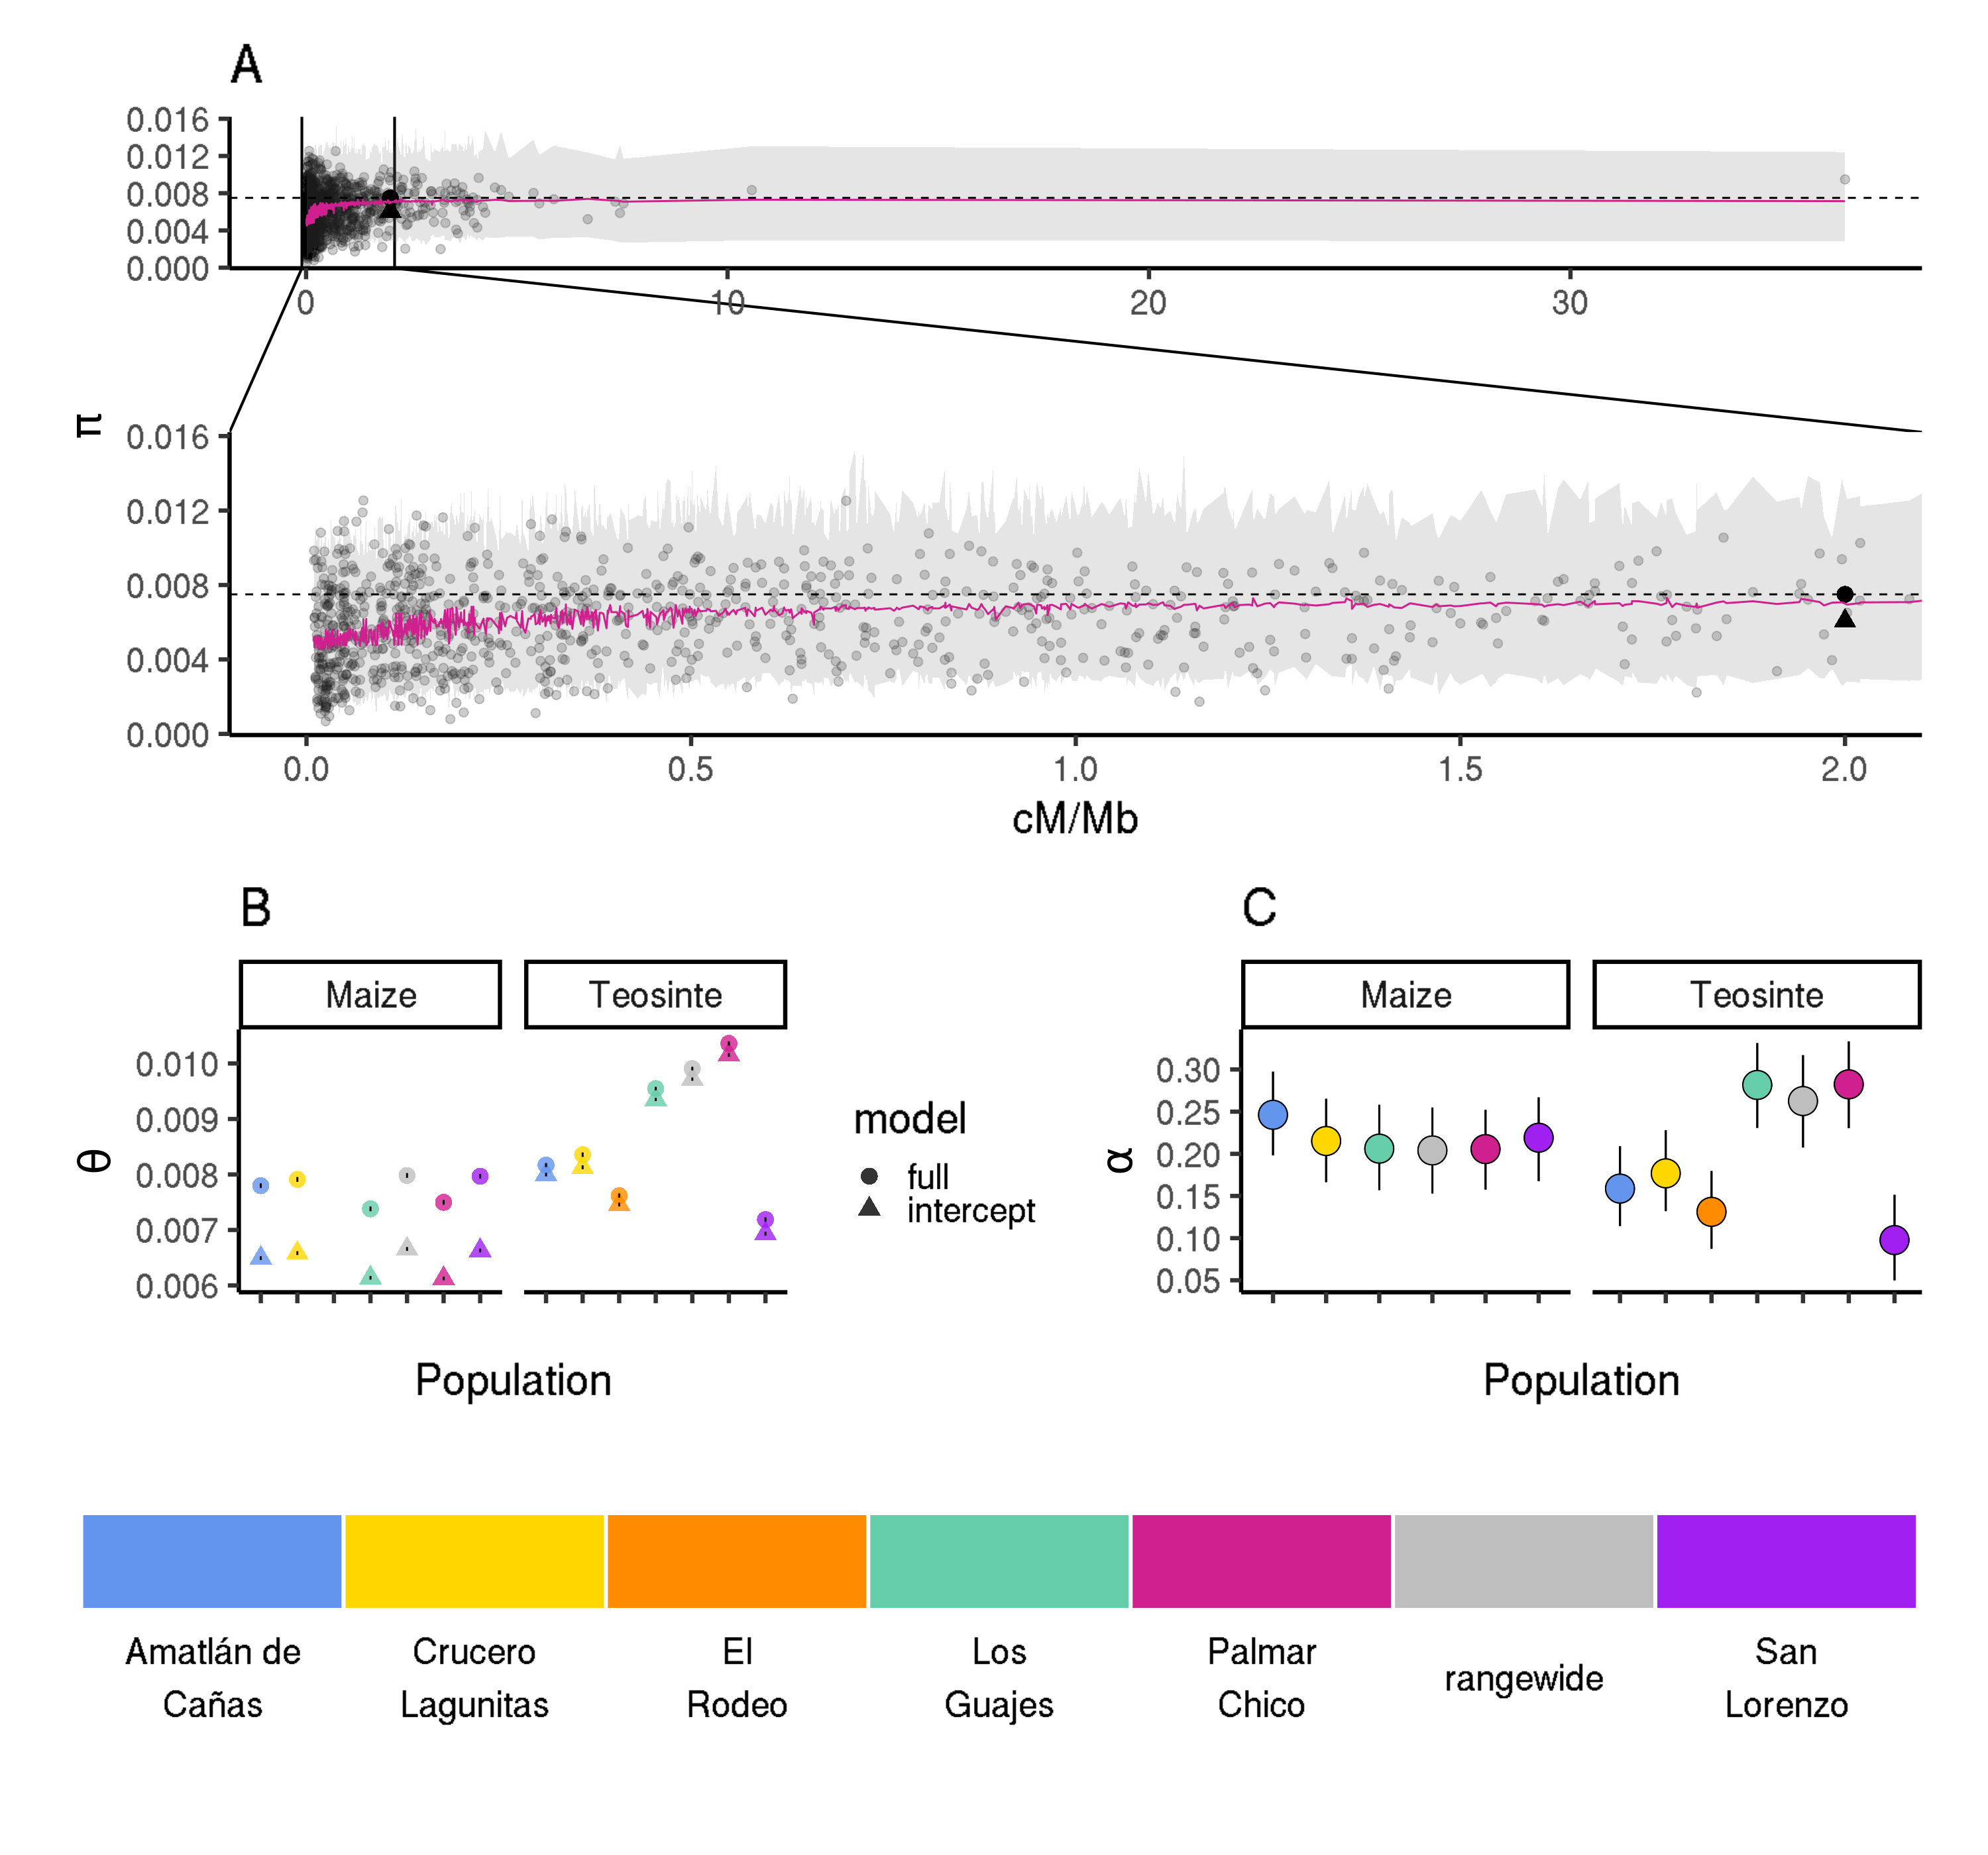

In [6]:
options(repr.plot.width = 15, repr.plot.height = 14, repr.plot.res = 200)

theta_plot <- 
 plot_df %>% 
    ggplot() +
    geom_point(data = , mapping = aes(pop, value, colour = color, shape = model), size = 4, alpha = 0.8, inherit.aes = F) +
    geom_segment(mapping = aes(x = pop, xend = pop, y = lower, yend = upper), colour = "black") +
    facet_wrap(~ssp, labeller = labeller(ssp = c("Teo" = "Teosinte", "LR" = "Maize"))) +
    theme(axis.text.x = element_blank(), strip.text.x = element_text(size = tts_small)) +
    xlab("\nPopulation") +
    ylab(expression(theta)) +
    scale_color_identity()


leg_df <- 
color_df %>% 
    mutate(pop = str_replace(pop, "LR_|Teo_", "")) %>% 
    filter(!pop %in% c("Palmar_Chico", "random2_Palmar_Chico")) %>%
    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
    mutate(pop = ifelse(pop == "random", "rangewide", pop)) %>% 
    arrange(pop)


alpha_plot <- plot_df %>% 
    ggplot(aes(pop, alpha, fill = color)) +
    geom_segment(aes(x = pop, y = low, xend = pop, yend = high), colour = "black") +
    geom_point(size = 7, pch = 21) +
    facet_wrap(~ssp, scales = "free_x", nrow = 1, labeller = labeller(ssp = c("Teo" = "Teosinte", "LR" = "Maize"))) +
    labs(fill = "") +
    ylab(expression(alpha)) +
    xlab("\nPopulation") +
    theme(axis.text.x = element_blank(), legend.position = "n",
         strip.text.x = element_text(size = tts_small)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 10)) +
    scale_fill_identity()

theta_alpha_plot <- 
plot_df %>% 
    filter(model == "full") %>% 
    ggplot(aes(value, alpha, colour = color)) +
    geom_point(size = 7) +
    #geom_segment(aes(x = value, y = low, xend = value, yend = high), colour = "black") +
    #geom_segment(aes(x = lower, y = alpha, xend = upper, yend = alpha), colour = "black") +
    facet_wrap(~ssp, scales = "free", labeller = labeller(ssp = c("Teo" = "Teosinte", "LR" = "Maize"))) +
    theme(strip.text.x = element_text(size = tts_small)) +
    scale_color_identity(guide = "legend", labels = str_remove_all(leg_df$pop, "random1 "), breaks = leg_df$color) +
    xlab(expression(theta[full])) +
    ylab(expression(alpha)) +
    labs(color="")

with(filter(plot_df, ssp == "Teo"),  cor.test(value, alpha, method = "spearman"))
summary(lm(alpha ~ value, data = filter(plot_df, ssp == "Teo")))
with(filter(plot_df, ssp == "LR"),  cor.test(value, alpha, method = "spearman"))
summary(lm(alpha ~ value, data = filter(plot_df, ssp == "LR")))


#plot_grid(pi_rate + ggtitle("A"), theta_plot + ggtitle("B"), alpha_plot + ggtitle("C"), theta_alpha_plot + theme(legend.position="n") + ggtitle("D")) /
#make_legplot(text_size = 7) + plot_layout(heights = c(10,2)) +
#ggsave("../figures/Figure3.pdf", width = 17, height = 14)

#no D for revision
bottom  <- plot_grid(theta_plot + ggtitle("B"), (alpha_plot + ggtitle("C")), rel_widths = c(1.2,1))
plot_grid(pi_rate + ggtitle("A"), bottom, nrow = 2, rel_heights = c(1.5,1)) /
make_legplot(text_size = 7) + plot_layout(heights = c(4,1), nrow = 2) +
ggsave("../figures/Figure3.pdf", width = 15, height = 14)

#bottom  <- plot_grid(theta_plot + ggtitle("B"), (alpha_plot + ggtitle("C")), rel_widths = c(1.2,1))
#plot_grid(pi_rate + ggtitle("A"), theta_plot + ggtitle("B"), (alpha_plot + ggtitle("C")), nrow = 3, rel_heights = c(1.5,1)) /
#make_legplot(text_size = 7) + plot_layout(heights = c(4,1), nrow = 2)



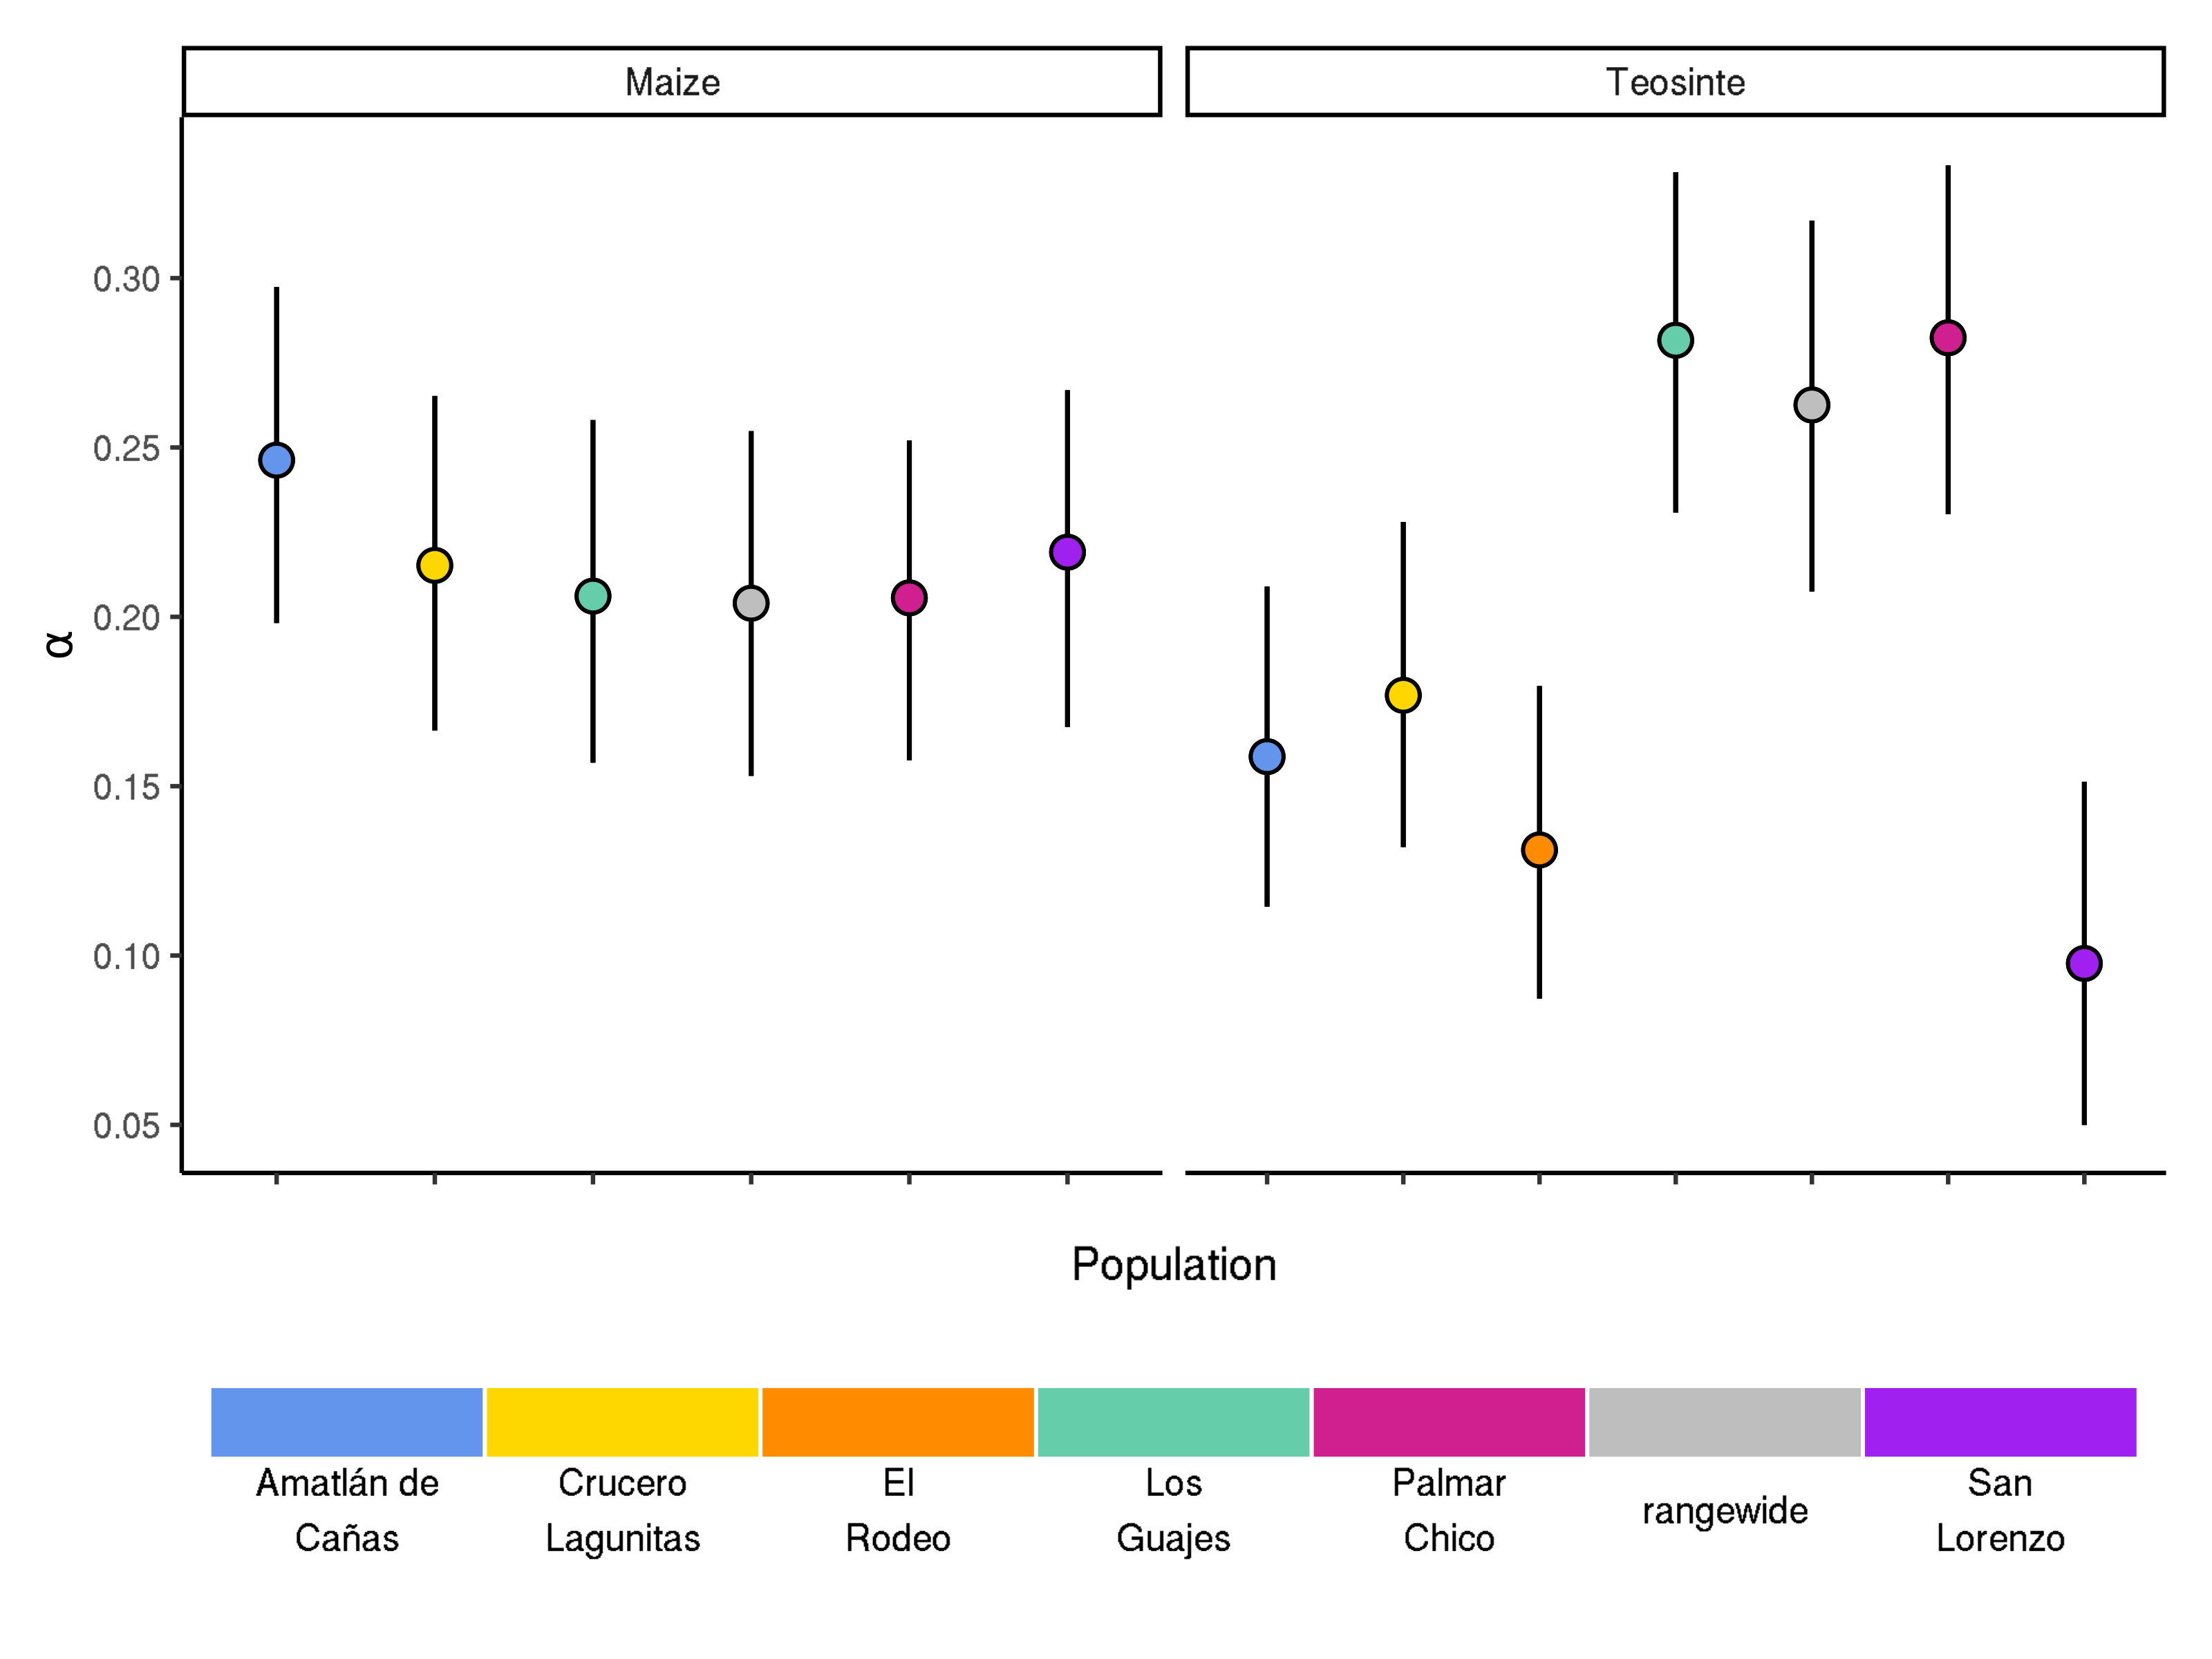

In [19]:
alpha_plot <- plot_df %>% 
    ggplot(aes(pop, alpha, fill = color)) +
    geom_segment(aes(x = pop, y = low, xend = pop, yend = high), colour = "black", lwd = 1.2) +
    geom_point(size = 7, pch = 21, stroke = 1.5) +
    facet_wrap(~ssp, scales = "free_x", nrow = 1, labeller = labeller(ssp = c("Teo" = "Teosinte", "LR" = "Maize"))) +
    labs(fill = "") +
    ylab(expression(alpha)) +
    xlab("\nPopulation") +
    theme(axis.text.x = element_blank(), legend.position = "n",
         strip.text.x = element_text(size = tts_small)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 10)) +
    scale_fill_identity()


alpha_plot +  make_legplot(text_size = 7) + plot_layout(heights = c(4,1), nrow = 2)
ggsave("/home/stittes/parv_local_overleaf/corn_cab_elife/Figure3.pdf", width = 15, height = 14)


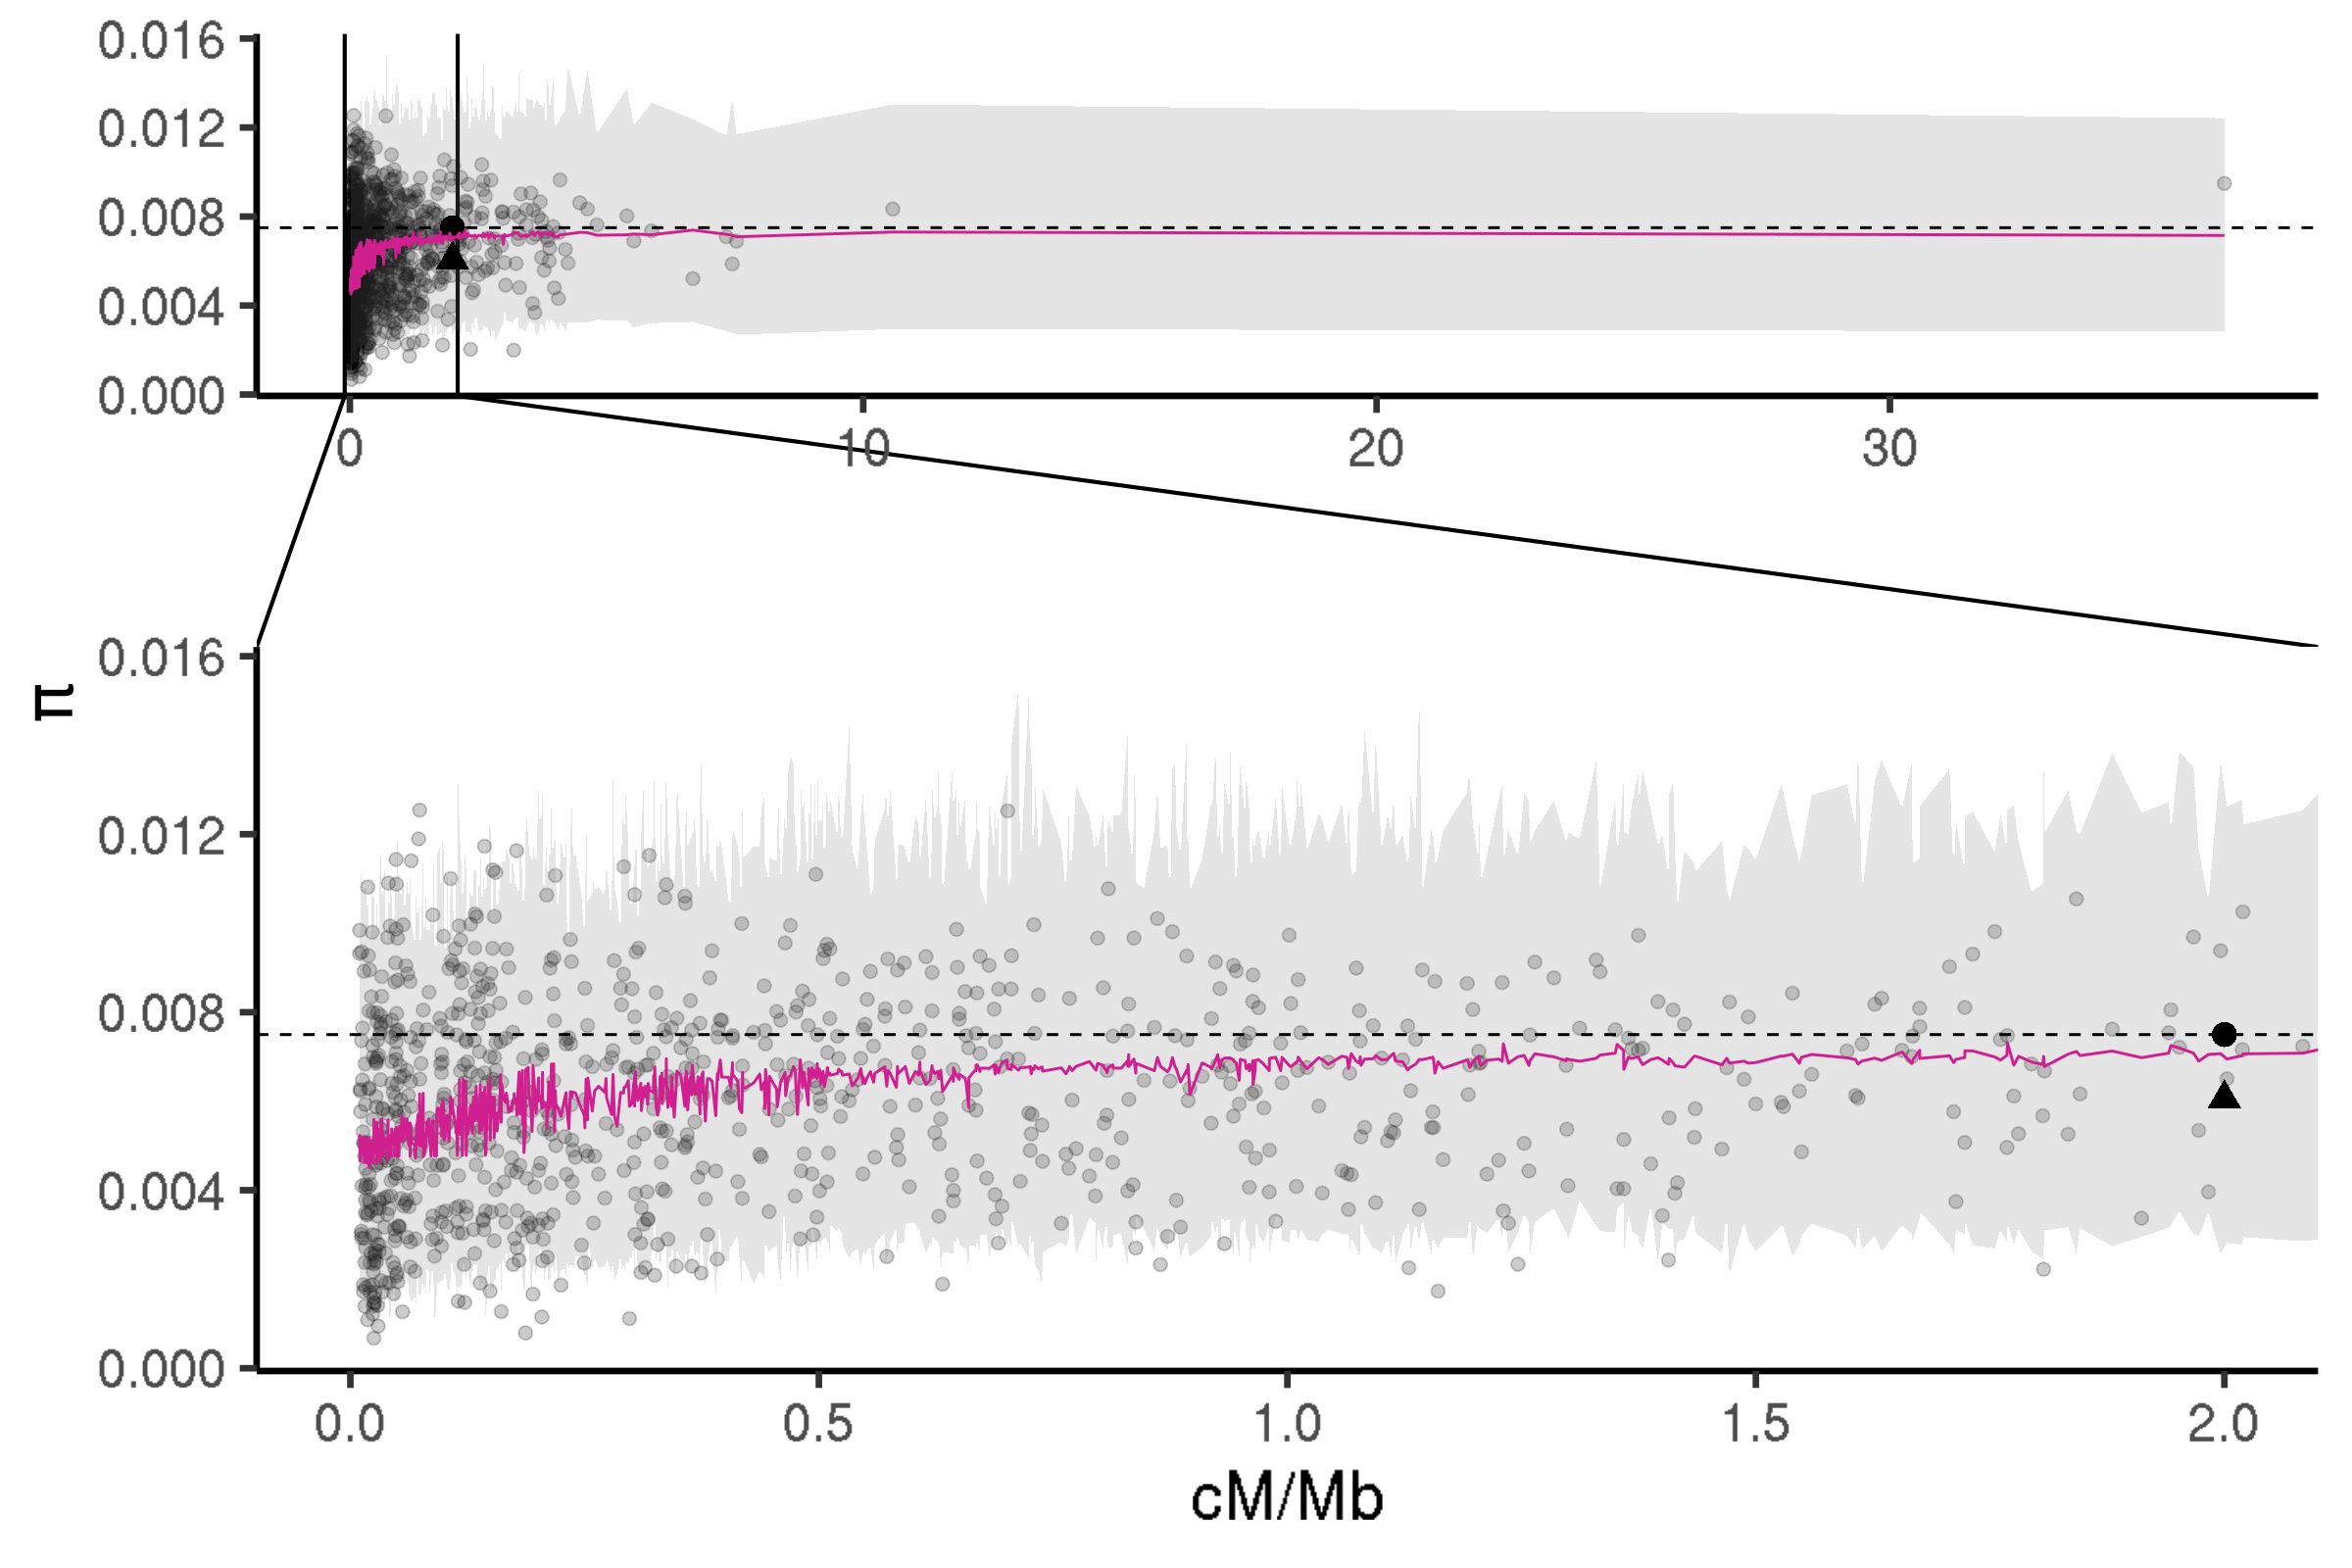

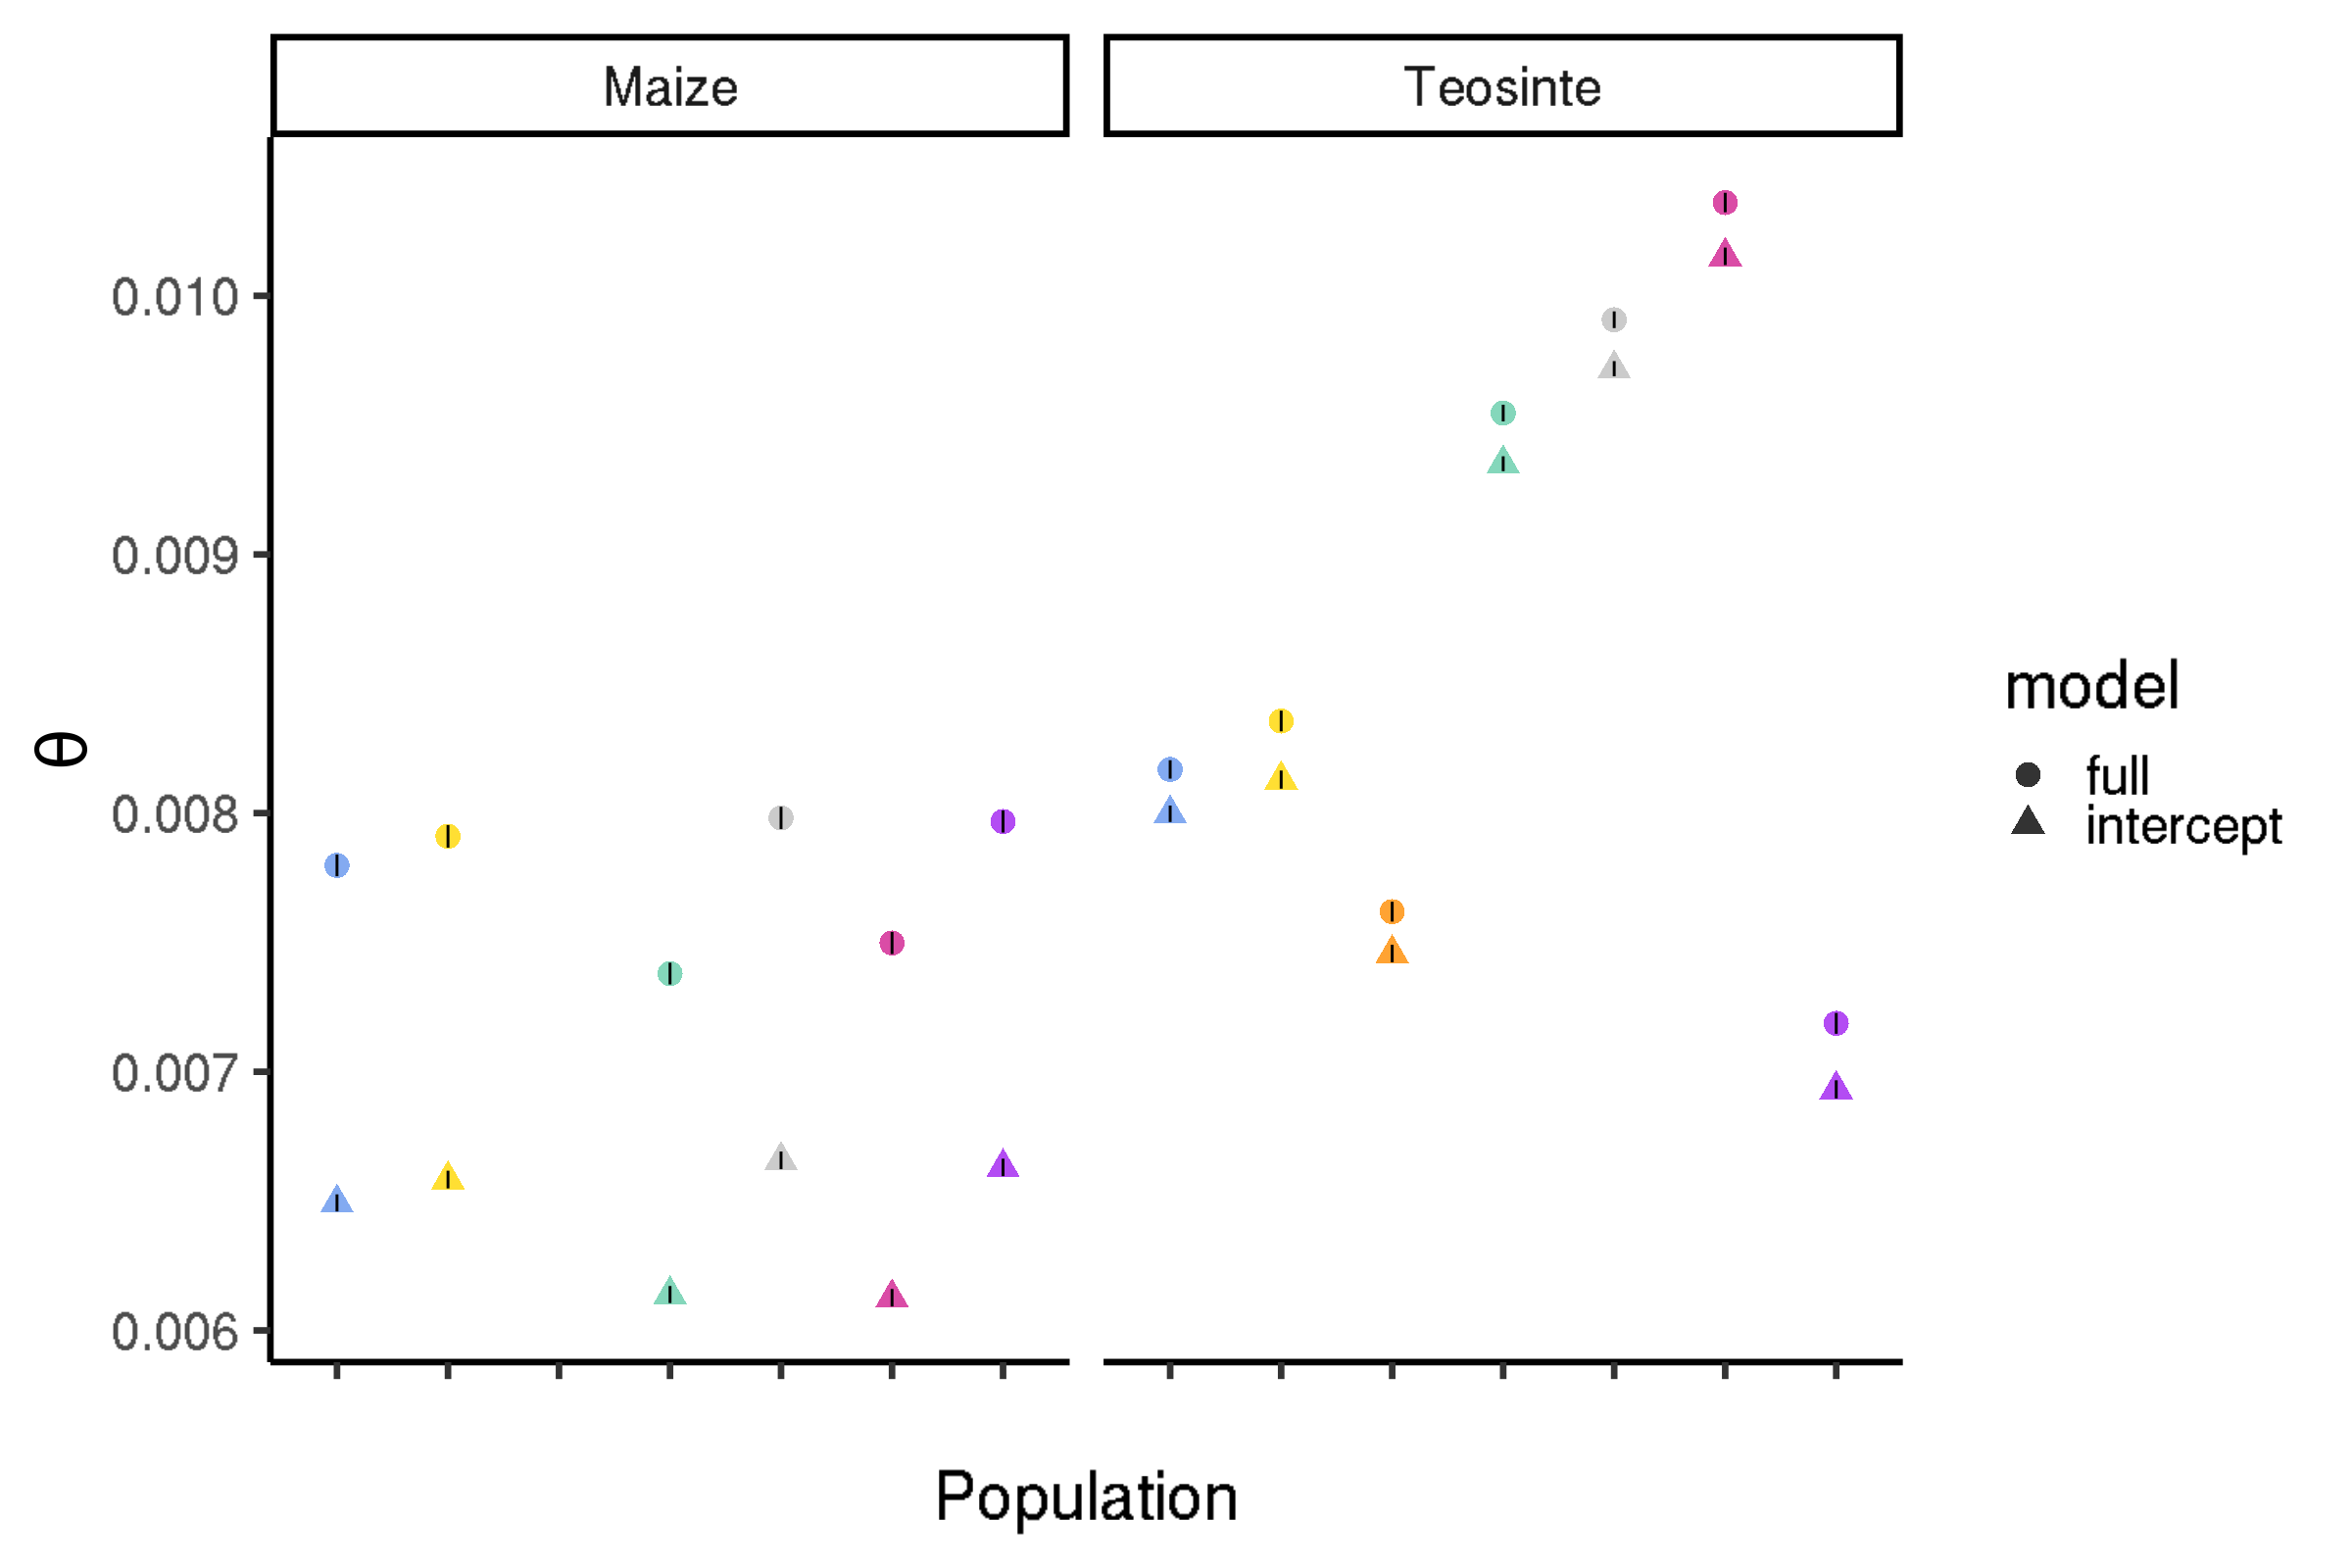

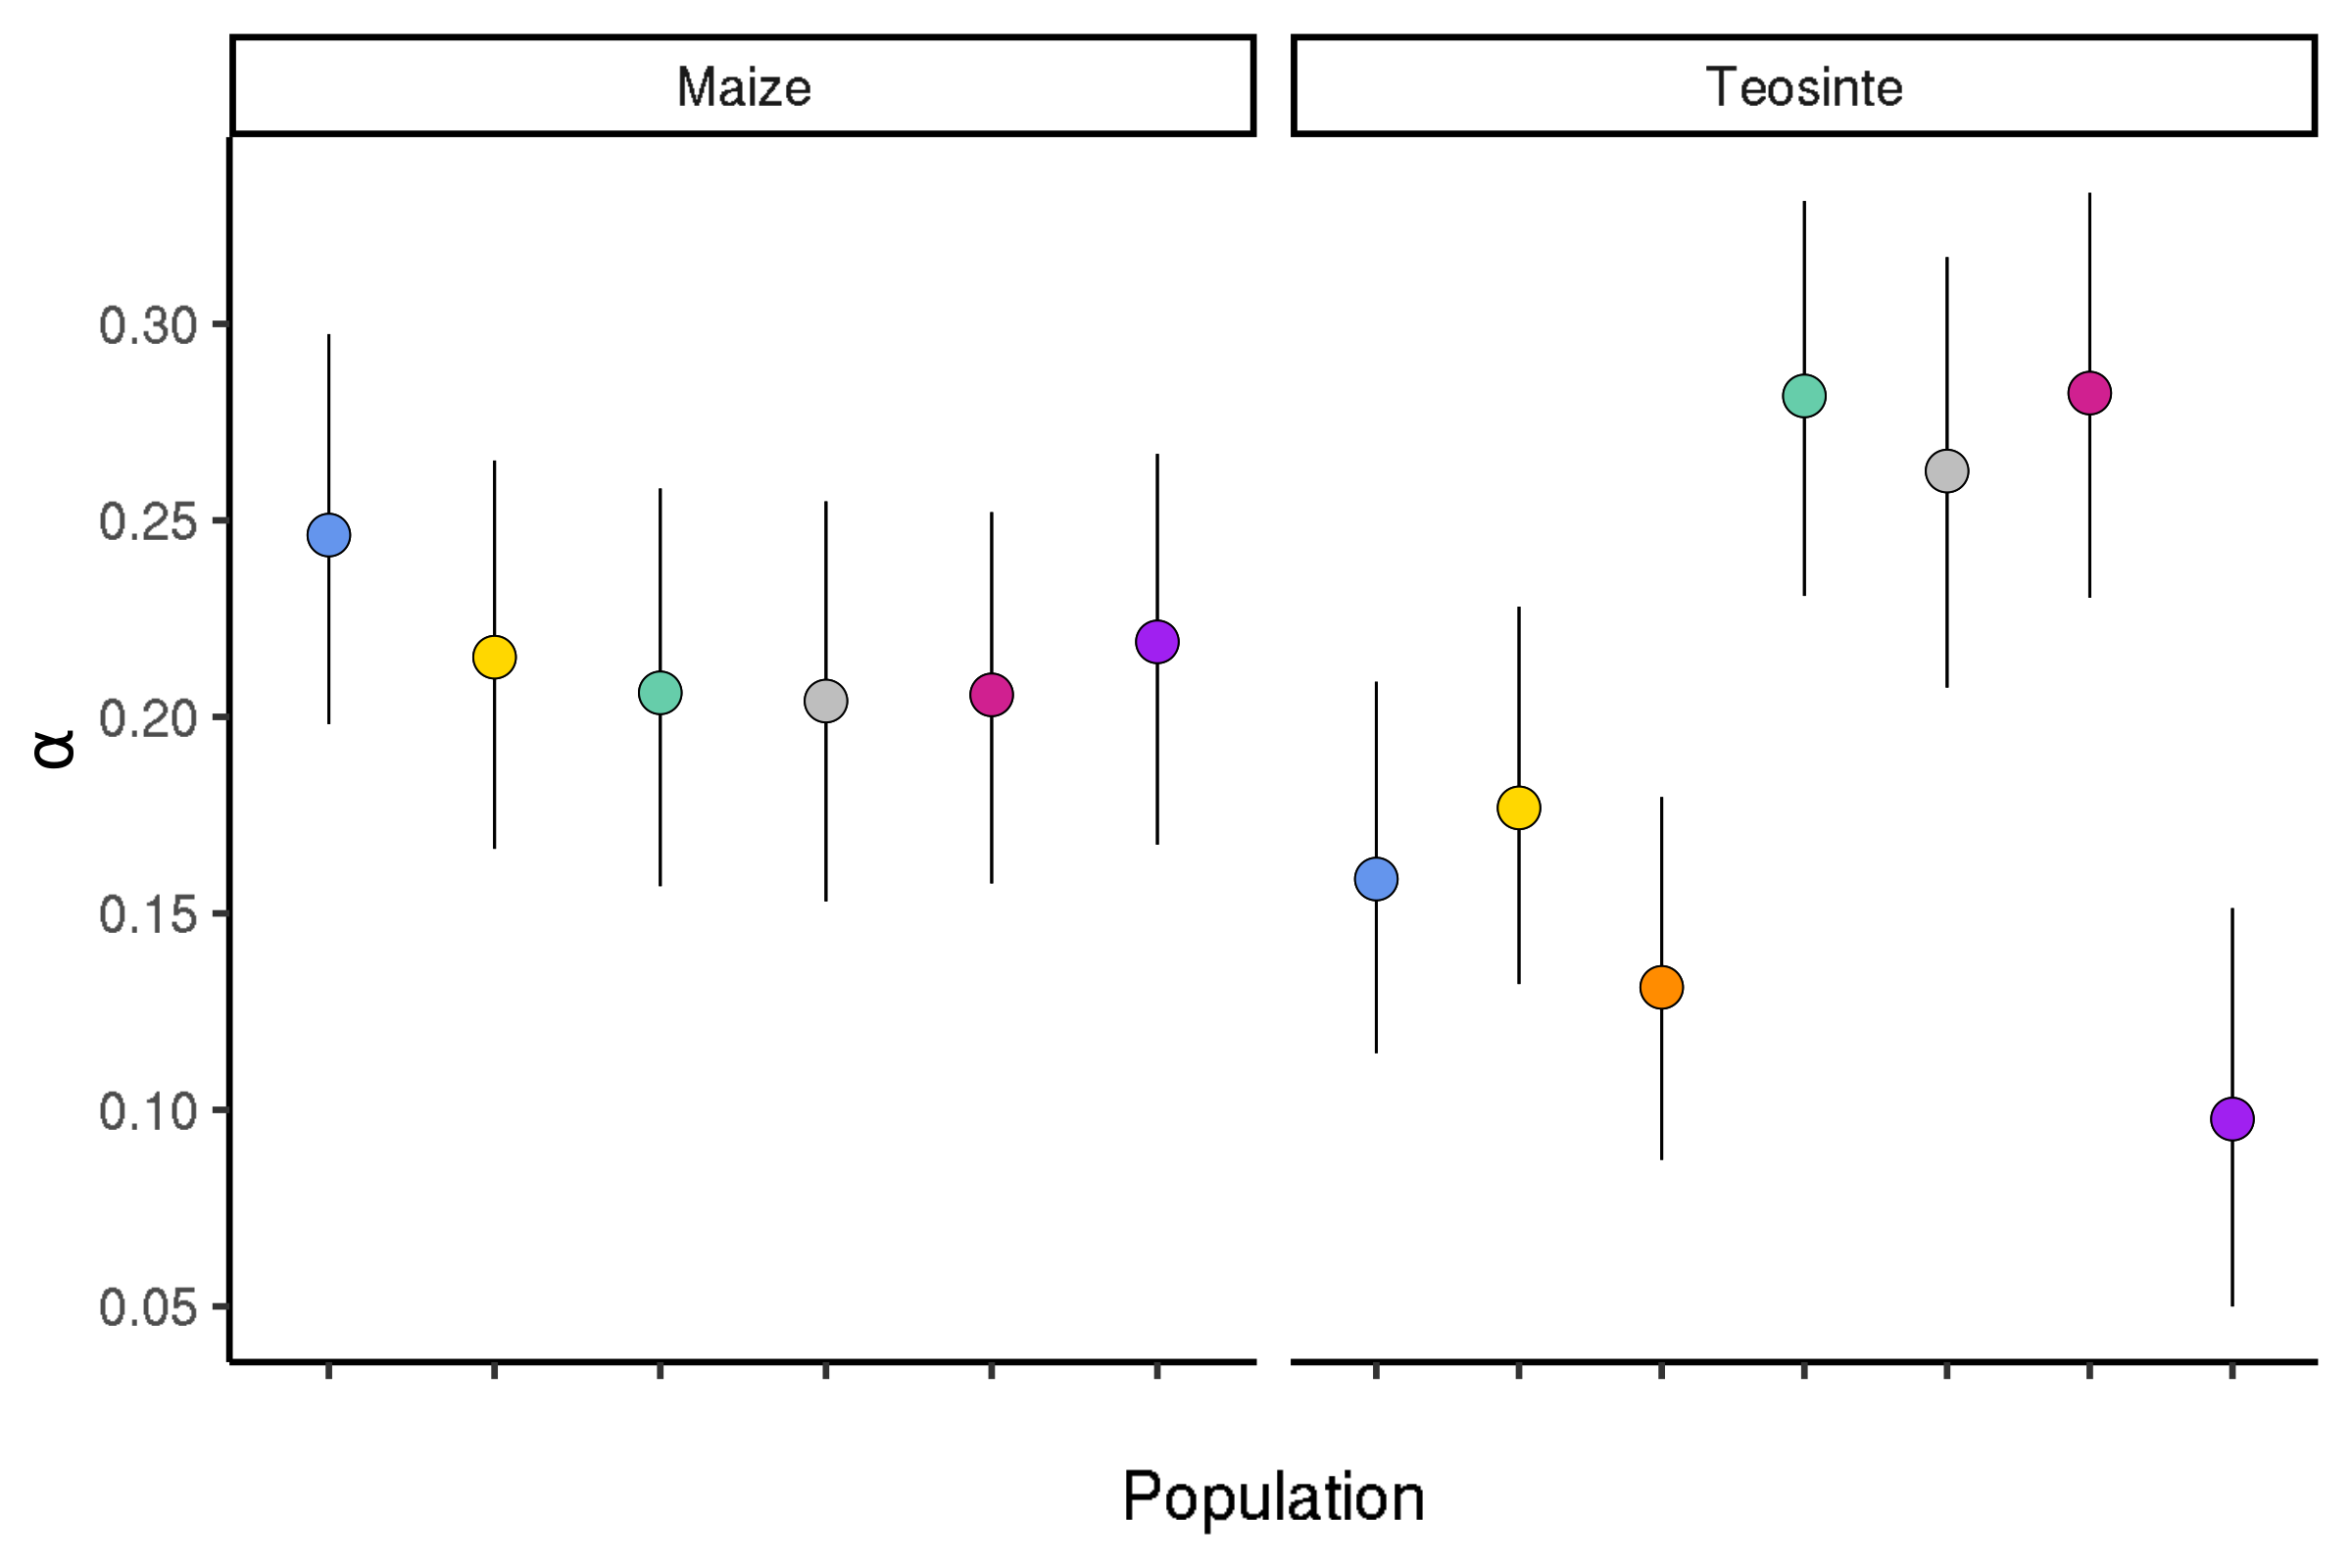

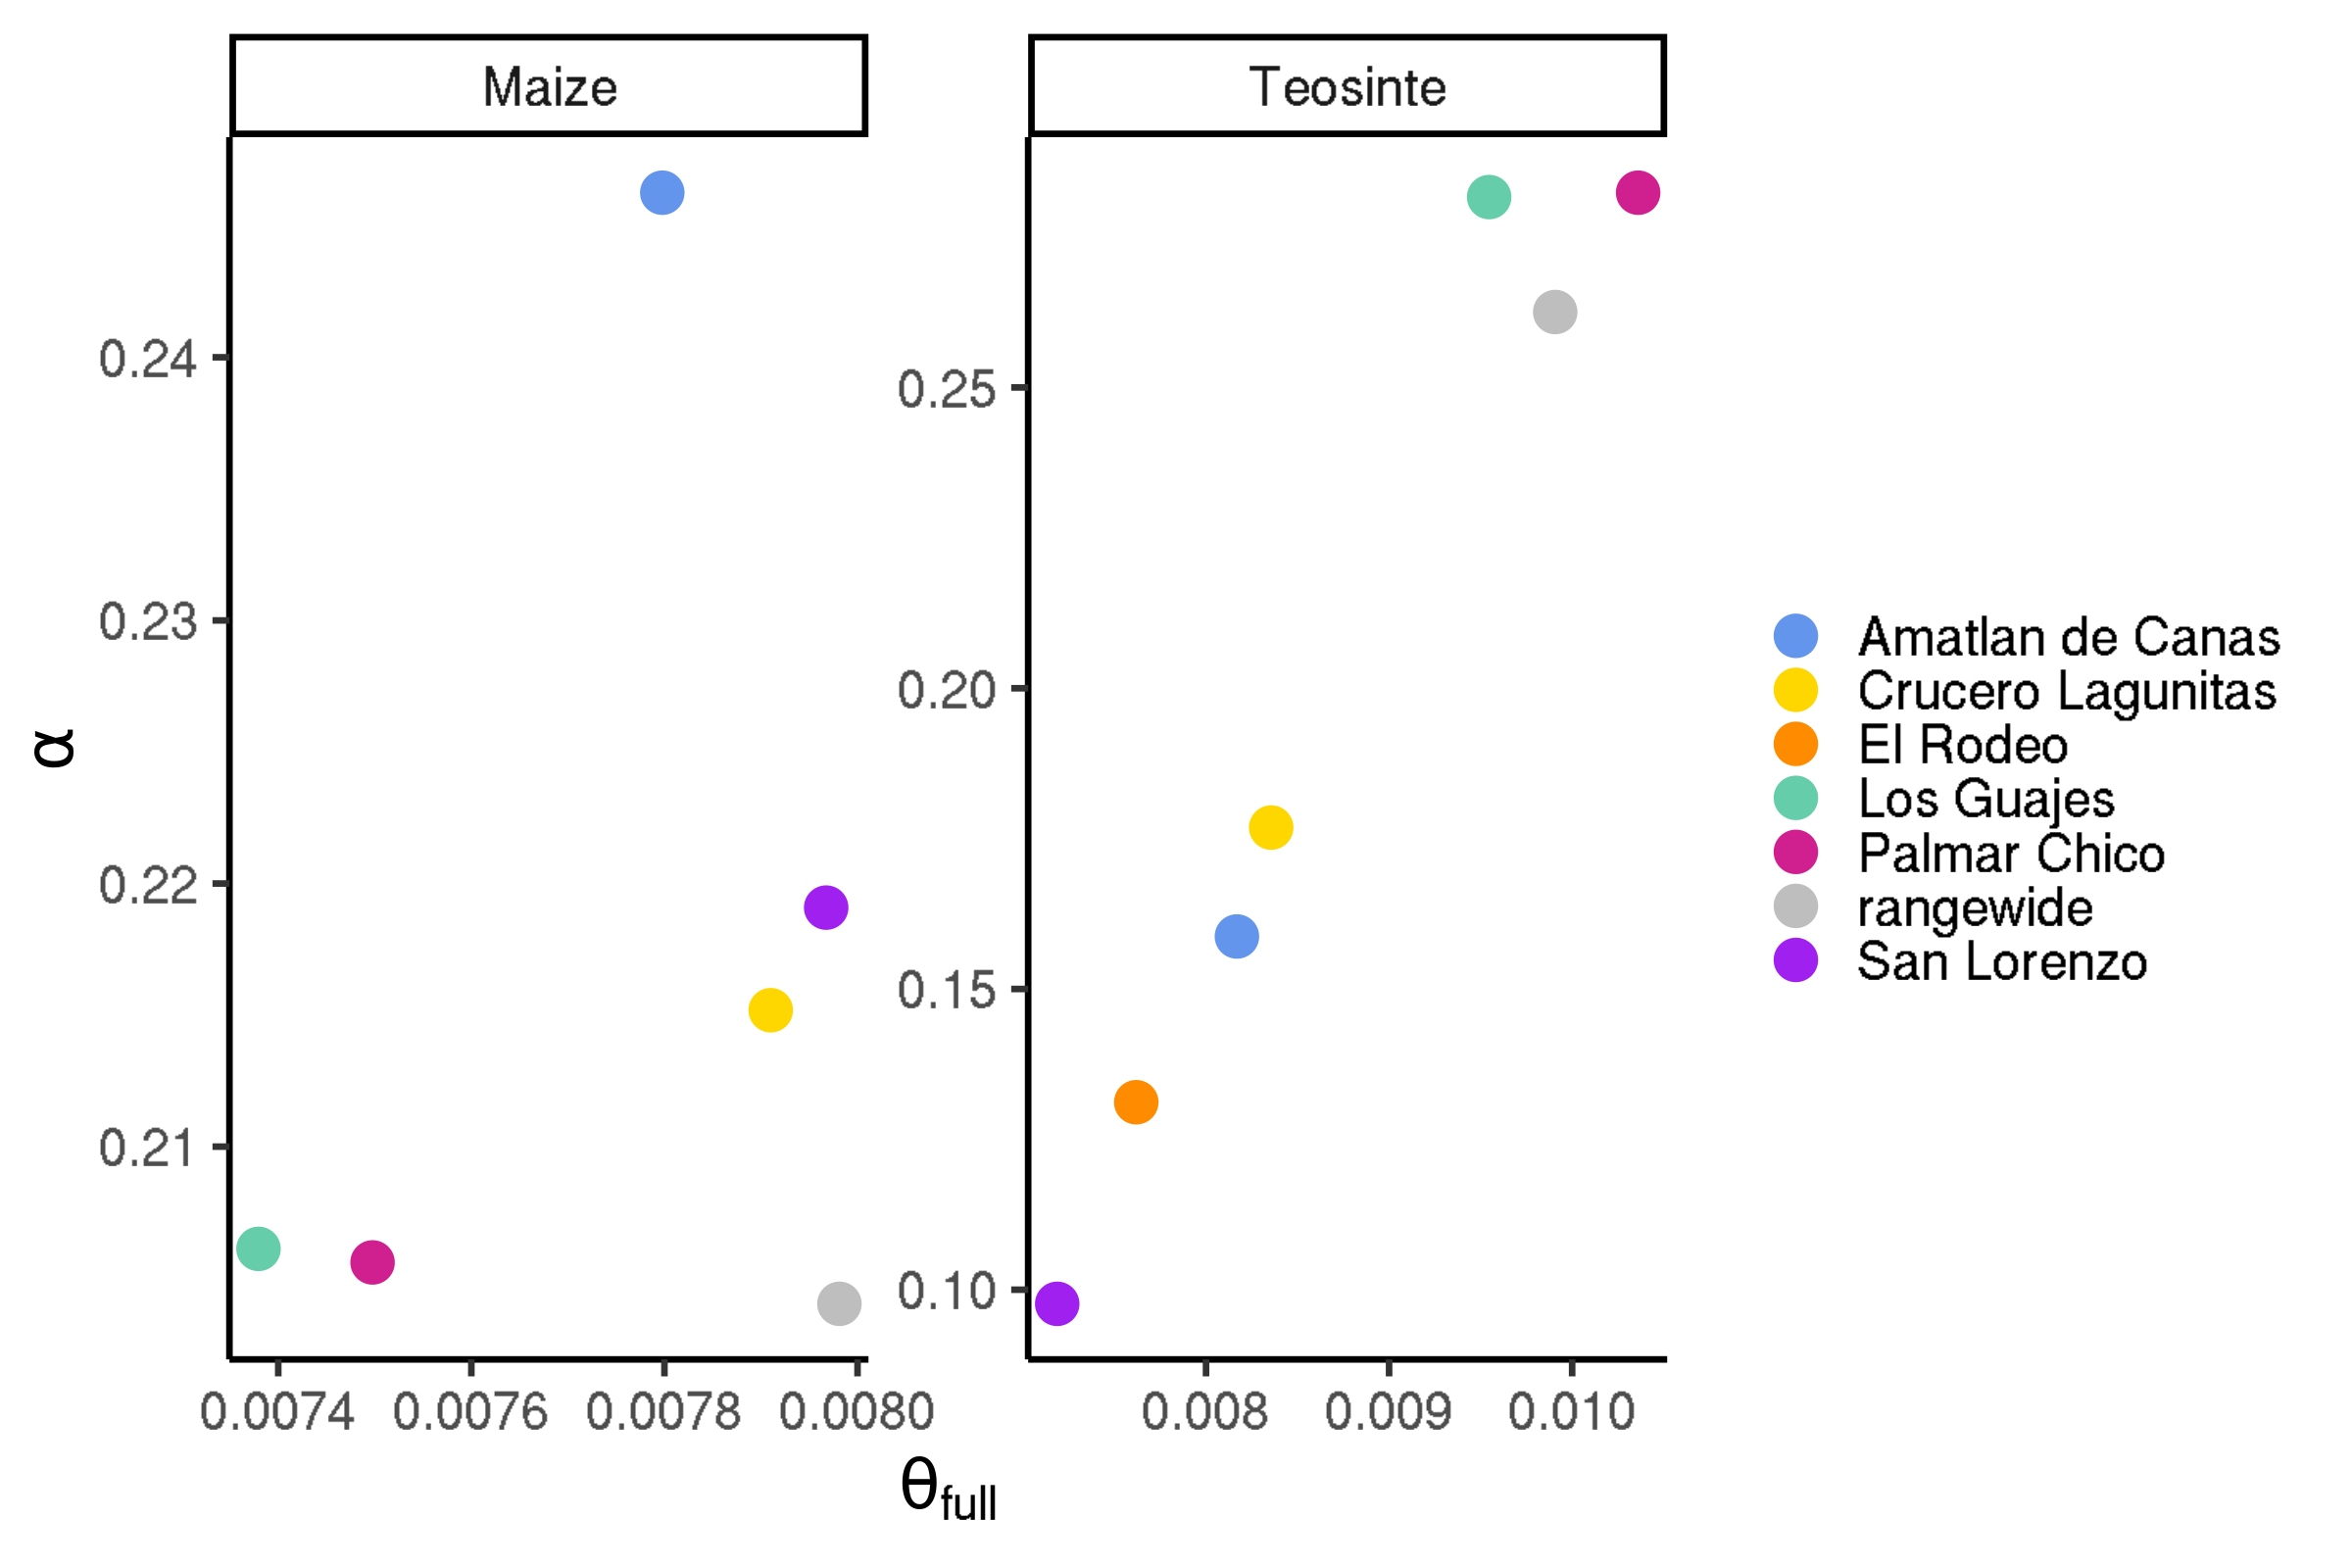

In [7]:
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 200)

theme_set(theme_classic(25))
pi_rate 
theta_plot 
alpha_plot          
theta_alpha_plot 

`summarise()` has grouped output by 'ssp'. You can override using the `.groups` argument.



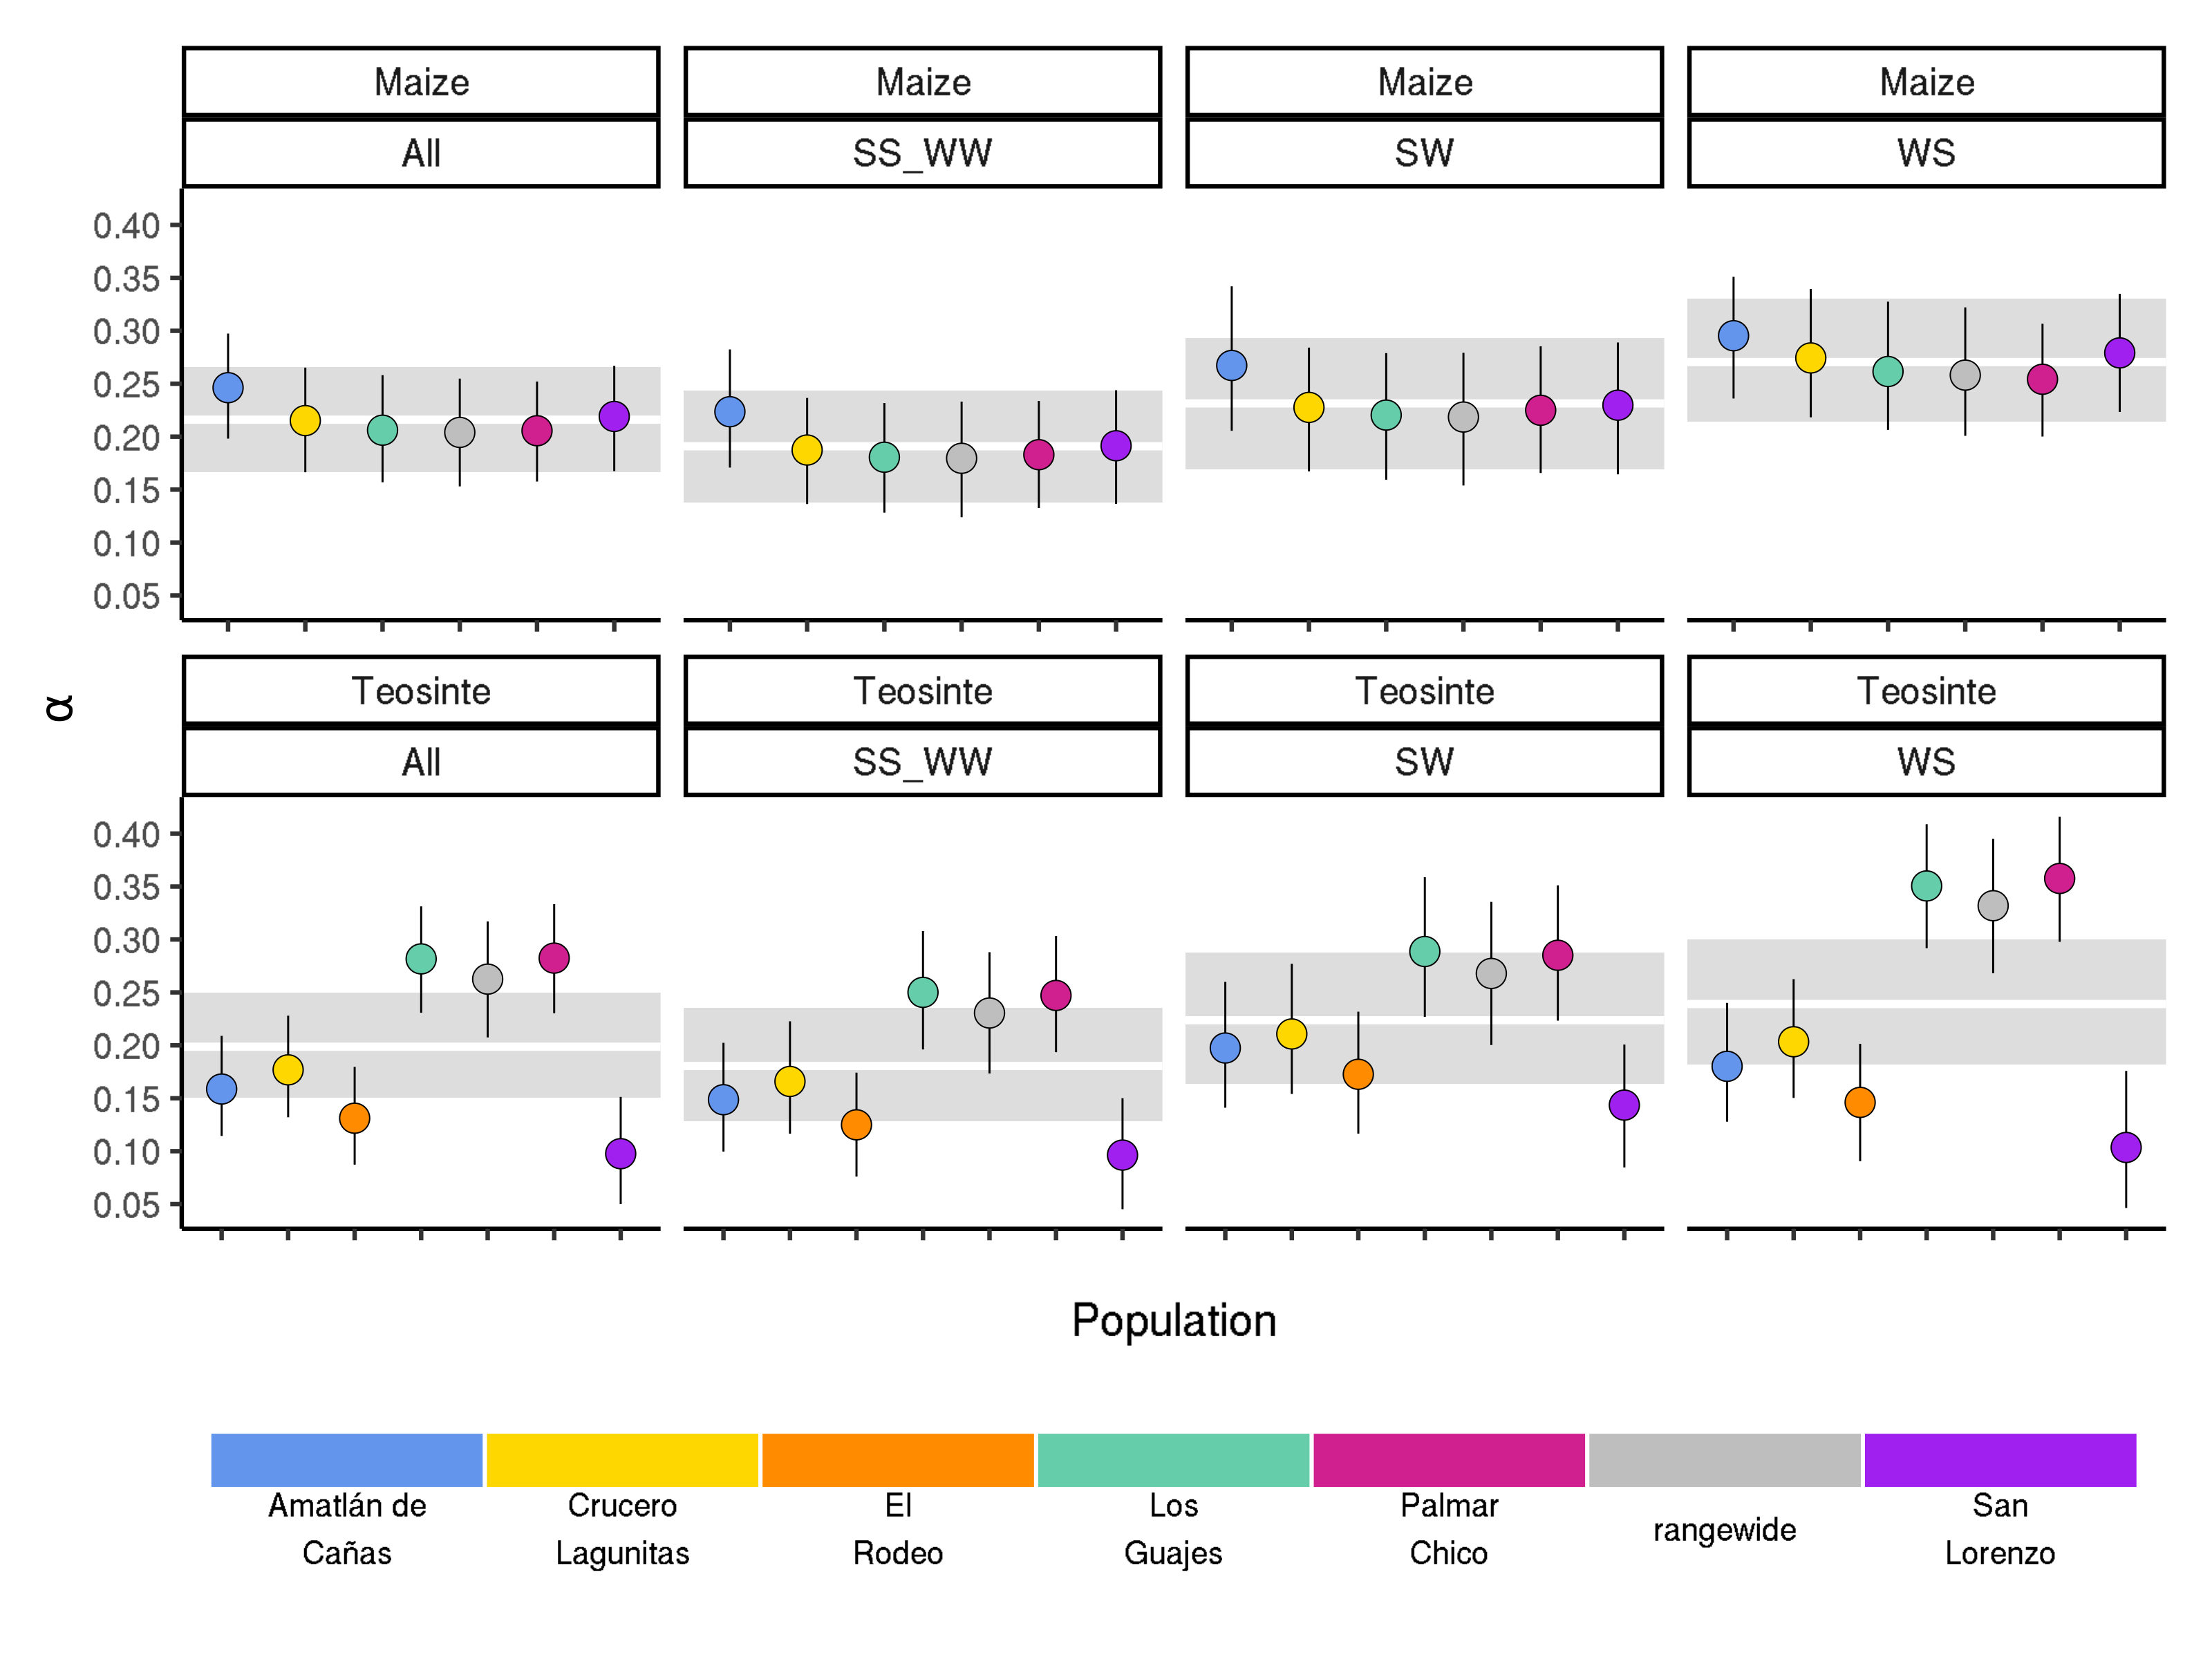

In [8]:
tts <- 24
tts_small <- 20
theme_set(theme_classic(base_size = tts))
options(repr.plot.width = 16, repr.plot.height = 12, repr.plot.res = 200)


nuc_df <- 
full_pred %>% 
  filter(!pop %in% c("LR_random2_Palmar_Chico", "LR_Palmar_Chico", "Teo_random2_Palmar_Chico", "Teo_Palmar_Chico"))  %>% 
  mutate(pop = str_remove_all(pop, "(LR_|Teo_)")) %>%
  full_join(., model_plot_df, by = c("pop", "ssp")) %>% 
  filter(model == "full")


nuc_summ_df <- nuc_df %>% 
    group_by(ssp, nuc_type) %>% 
    summarise(alpha = mean(alpha), low = mean(low), high = mean(high))


nuc_plot <- 
    ggplot() +
    geom_rect(data = nuc_summ_df, mapping = aes(xmin = -Inf, xmax = Inf, ymin = low, ymax = high), alpha  = 0.2) +
    geom_hline(data = nuc_summ_df, mapping = aes(yintercept = alpha), colour = "white", lwd = 2) +
    geom_segment(data = nuc_df, aes(x = pop, y = low, xend = pop, yend = high), colour = "black") +
    geom_point(data = nuc_df, aes(pop, alpha, fill = color), size = 7, pch = 21) +
    facet_wrap(~ssp+nuc_type, scales = "free_x", nrow = 2, labeller = labeller(ssp = c("Teo" = "Teosinte", "LR" = "Maize"))) +
    labs(fill = "") +
    ylab(expression(alpha)) +
    xlab("\nPopulation") +
    theme(axis.text.x = element_blank(), legend.position = "n",
         strip.text.x = element_text(size = tts_small)) +
    scale_y_continuous(breaks = scales::pretty_breaks(n = 10)) +
    scale_fill_identity() 


nuc_plot + make_legplot(text_size = 6) + plot_layout(heights = c(10,2))
ggsave("../figures/supplement_mk.pdf", width = 16, height = 12)




## $\theta$ and number of sweeps  

In [9]:
pops_to_count <- c(
    "LR--Amatlan_de_Canas", 
    "LR--Crucero_Lagunitas", 
    "LR--Los_Guajes", 
    "LR--random1_Palmar_Chico",
    "LR--random",
    "LR--San_Lorenzo", 
    "Teo--Amatlan_de_Canas", 
    "Teo--Crucero_Lagunitas", 
    "Teo--El_Rodeo", 
    "Teo--Los_Guajes", 
    "Teo--random1_Palmar_Chico", 
    "Teo--random", 
    "Teo--San_Lorenzo"
)

colz_df <- color_df %>% 
    mutate(
        pop = str_replace_all(pop, "^random$", "rangewide"),
        pop = str_replace_all(pop, "LR_", "LR--"),
        pop = str_replace_all(pop, "Teo_", "Teo--")
    ) %>% 
    distinct()

colz_df

population <- str_replace_all(pops_to_count, "^random$", "rangewide")


counts <- pops_to_count %>% map_dbl(~{
    vroom::vroom(str_glue("../data/raisd/v5--{.x}.corrected_block_outliers_merged.txt")) %>% 
    nrow()
})

count_df <- tibble(
        population = population,
        counts = counts) %>% 
        separate(population, c("ssp", "pop"), "--")

 
theta_sweepcount_df <- full_join(plot_df, count_df, by = c("ssp", "pop")) %>% 
    filter(model == "full")

theta_sweepcount_df %>% 
    ggplot(aes(value, counts, colour = color)) +
    geom_point(size = 10) +
    facet_wrap(~ssp, scales = "free") +
    scale_color_identity()


theta_sweepcount_df

pop,color
<chr>,<chr>
LR--Los_Guajes,mediumaquamarine
Teo--Los_Guajes,mediumaquamarine
LR--Crucero_Lagunitas,gold
Teo--Crucero_Lagunitas,gold
LR--El_Rodeo,darkorange
Teo--El_Rodeo,darkorange
LR--Amatlan_de_Canas,cornflowerblue
Teo--Amatlan_de_Canas,cornflowerblue
LR--San_Lorenzo,purple


ERROR: Error: '../data/raisd/v5--LR--Amatlan_de_Canas.corrected_block_outliers_merged.txt' does not exist in current working directory ('/group/jrigrp10/stittes/parv_local_v5_til11/notebooks').


In [ ]:
with(filter(theta_sweepcount_df, ssp == "LR"), cor.test(value, counts, method = "spearman"))   
with(filter(theta_sweepcount_df, ssp == "Teo"), cor.test(value, counts, method = "spearman"))    

## $\theta$ and count of fixed substitutions

In [ ]:
fixed_theta_df <- read_csv("aMK_fixedDF.csv") %>% 
    mutate(pop = str_remove_all(pop, "LR_|Teo_")) %>% 
    filter(!pop %in% c("random2_Palmar_Chico", "Palmar_Chico")) %>% 
    full_join(., theta_sweepcount_df, by = c("ssp", "pop"))


fixed_theta_df %>% 
ggplot(aes(value, fixed_sel_mean, colour = color)) +
    geom_point(size = 10) +
    geom_segment(aes(x = value, xend = value, y = fixed_low, yend = fixed_high)) +
    facet_wrap(~ssp, scales = "free") +
    scale_color_identity() +
    ylab("Adaptive substitutions") +
    xlab(expression(theta))


with(filter(fixed_theta_df, ssp == "LR"), cor.test(value, fixed_sel_mean, method = "spearman"))   
with(filter(fixed_theta_df, ssp == "Teo"), cor.test(value, fixed_sel_mean, method = "spearman"))    

In [ ]:
fixed_theta_df %>% 
ggplot(aes(value, alpha, colour = color)) +
    geom_point(size = 10) +
    geom_segment(aes(x = value, xend = value, y = alpha_low, yend = alpha_high)) +
    facet_wrap(~ssp, scales = "free") +
    scale_color_identity() +
    ylab("Adaptive substitutions") +
    xlab(expression(theta))


In [ ]:
#get value that is 95% of theta for each pop
#Get the smallest rec. rate value that gets expecte pi to 95% theta value above 
#calculate the fraction of available basepairs that fall in that range
#summarize

 linkedsel_val_df %>% 
    filter(param == "theta") %>% 
    group_by(pop) %>% 
    mutate(
        total_bp = sum(end - start),
        theta = unique(value), 
        theta_95 = unique(value)*0.95)  %>% 
        filter(expected_pi >= theta_95) %>% 
    summarise(
        min_r = quantile(rbp_i, 0),
        min_fraction = 1 - sum(end - start) / total_bp
        )  %>% 
    distinct() %>% 
    mutate(ssp = ifelse(grepl("Teo", pop), "Teo", "Maize")) %>% 
    group_by(ssp) %>% 
    summarise(
        mean_r = mean(min_r),
        se_r = sd(min_r) / sqrt(n()),
        bp_frac = mean(min_fraction),
        se_bp_frac = sd(min_fraction) / sqrt(n())
    )

